In [1]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV ,KFold
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.calibration import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
# df = pd.read_csv('/Users/hneen./iCloud Drive (Archive)/Desktop/L9/Graduation project/colon_predicitions/Data/colon-dataset-processed.csv')
df = pd.read_csv('../Data/colon-dataset-processed.csv')
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])
df

,Class,Age,p16540_C/C,p16540_G/C,p16540_G/G,p16580_C/C,p16580_C/T,p16580_T/T,mdm2_G/G,mdm2_G/T,mdm2_T/T,GAL3_A/A,GAL3_C/A,GAL3_C/C,TIM1_C/C,TIM1_G/C,TIM1_G/G
0,1,49,False,True,False,True,False,False,True,False,False,False,True,False,False,True,False
1,1,49,False,True,False,True,False,False,True,False,False,True,False,False,False,True,False
2,1,49,False,True,False,True,False,False,False,True,False,False,True,False,True,False,False
3,1,36,False,True,False,True,False,False,False,False,True,False,True,False,True,False,False
4,1,49,True,False,False,False,True,False,False,False,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,0,81,False,True,False,True,False,False,False,False,True,False,False,True,False,False,True
111,0,73,True,False,False,True,False,False,False,False,True,False,False,True,False,False,True
112,0,56,True,False,False,True,False,False,False,True,False,False,False,True,False,True,False
113,0,74,False,True,False,False,True,False,True,False,False,False,False,True,False,False,True


In [3]:
X=df.drop('Class',axis=1)
y=df['Class']

In [4]:

#split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
random_state=123

In [5]:
X_test.shape , X_train.shape

((23, 16), (92, 16))

In [6]:
#overampling
sm = SMOTE(random_state=random_state)
X_oversampled, y_oversampled = sm.fit_resample(X, y)

X_train_oversampled, X_test_oversampled, y_train_oversampled, y_test_oversampled = train_test_split(X_oversampled, y_oversampled, test_size=0.2, random_state=42)


In [7]:
#underampling
# rus = RandomUnderSampler(random_state=random_state)
rus = SMOTEENN(random_state=random_state, sampling_strategy='all')
X_undersampled, y_undersampled = rus.fit_resample(X, y)
X_train_undersampled, X_test_undersampled, y_train_undersampled, y_test_undersampled = train_test_split(X_undersampled, y_undersampled, test_size=0.2, random_state=42)

In [8]:
n_splits = 5

def GridSer_model(model_params,X_train,y_train):
    scores = []
    cv=KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    for model_name, mp in model_params.items():
        clf =  GridSearchCV(mp['model'], mp['params'], cv=cv, return_train_score=False,n_jobs=-1,error_score=0)
        clf.fit(X_train,y_train)
        best_model = mp['model'].set_params(**clf.best_params_)
        scores.append({
            'best_model': best_model,
            'model': model_name,
            'best_score': clf.best_score_,
            'best_params': clf.best_params_
        })
    return pd.DataFrame(scores,columns=['best_model','model','best_score','best_params']).sort_values(by=['best_score'], ascending=False)

In [9]:

def model_training(X_train, y_train, X_test,  y_test, models):
    
    # Create an empty DataFrame to store results
    results_df = pd.DataFrame(columns=['Model', 'Accuracy'])

    for model in models:
        
        model.fit(X_train, y_train)
        # Make predictions
        predictions = model.predict(X_test)
        
        # Evaluate the model
        accuracy = accuracy_score(y_test, predictions)
        precision =precision_score(y_test, predictions)
        recall= recall_score(y_test, predictions)
        cm=confusion_matrix(y_test, predictions)
        labels=model.classes_
        
        # Append results to the DataFrame
        temp_df = pd.DataFrame({'Model': [model.__class__.__name__], 'Accuracy': [accuracy], 'Precision': [precision], 'recall': [recall], 'cm':[cm],'labels':[labels]})
        results_df = pd.concat([results_df, temp_df], ignore_index=True)


    # Sort and return the results DataFrame
    return results_df.sort_values(by=['Accuracy'], ascending=False)


In [10]:
model_params = {
    
    'AdaBoostClassifier' : {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [50, 100, 200], 
            'learning_rate': [0.01, 0.1, 1]
        }
    } ,
    
    # 'ExtraTreesClassifier' : {
    #     'model': ExtraTreesClassifier(),
    #     'params': {
    #     'n_estimators': [50, 100, 200],
    #     'criterion': ['gini', 'entropy'],
    #     'max_depth': [None, 10, 20, 30],
    #     'min_samples_split': [2, 4, 6],
    #     'min_samples_leaf': [1, 2, 3],
    #     'max_features': ['sqrt', 'log2']
    #     }
    # },
    # 'LGBMClassifier' : {
    #     'model': LGBMClassifier(),
    #     'params': {
    #         'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
    #         'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    #         'n_estimators': [50, 100, 200],
    #         'num_leaves': [15, 31, 63, 127],
    #         'min_data_in_leaf': [5, 10, 20],
    #         'lambda_l2': [0.0, 0.1, 1.0]
    #     }
    # },
    # 'SVM':{
    #     'model': SVC(),
    #     'params': {
    #         'C': [0.1, 1, 10, 100], 
    #         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
    #     }
    # },

    #   'XGBClassifier' : {
    #     'model': XGBClassifier(),
    #     'params': {
    #         'n_estimators': [50, 100, 200], 
    #         'learning_rate': [0.01, 0.1, 1],
    #         'max_depth': [3, 5, 10],
    #         'gamma': [0, 0.1, 0.5, 1],
    #         'subsample': [0.5, 0.75, 1],
    #         'colsample_bytree': [0.5, 0.75, 1],
    #         'lambda': [0.0, 0.1, 1.0]
    #     }
    # },
    # 'RandomForestClassifier' : {
    #     'model': RandomForestClassifier(),
    #     'params': {
    #         'n_estimators': [50, 100, 200],
    #         'criterion': ['gini', 'entropy'],
    #         'max_depth': [None, 10, 20, 30],
    #         'min_samples_split': [2, 4, 6],
    #         'min_samples_leaf': [1, 2, 3],
    #         'max_features': ['auto', 'sqrt', 'log2']
    #     }
    # },
    'HistGradientBoostingClassifier':{
        'model': HistGradientBoostingClassifier(),
        'params': {
            'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
            'max_iter': [50, 100, 200],
            'max_leaf_nodes': [15, 31, 63, 127],
            'min_samples_leaf': [5, 10, 20],
            'l2_regularization': [0.0, 0.1, 1.0]
        }
    },
    # 'LogisticRegression' : {
    #     'model': LogisticRegression(),
    #     'params': {
    #         'C': [0.1, 1, 10, 100], 
    #         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    #     }
    # }
    
}

In [11]:
original = GridSer_model(model_params,X_train,y_train)

/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

In [12]:
original

,best_model,model,best_score,best_params
1,HistGradientBoostingClassifier(learning_rate=0...,HistGradientBoostingClassifier,0.890643,"{'l2_regularization': 0.0, 'learning_rate': 0...."
0,AdaBoostClassifier(learning_rate=0.01),AdaBoostClassifier,0.879532,"{'learning_rate': 0.01, 'n_estimators': 50}"


In [13]:
original['best_params'][1]

{'l2_regularization': 0.0,
 'learning_rate': 0.05,
 'max_iter': 200,
 'max_leaf_nodes': 15,
 'min_samples_leaf': 20}

In [14]:
models=original['best_model'].tolist()
model_training(X_train, y_train, X_test, y_test, models)


/var/folders/jh/zgqt24qj3_n6m12h05s8spkr0000gn/T/ipykernel_43968/4001924296.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)
/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


,Model,Accuracy,Precision,recall,cm,labels
0,HistGradientBoostingClassifier,0.782609,0.727273,0.8,"[[10, 3], [2, 8]]","[0, 1]"
1,AdaBoostClassifier,0.782609,0.777778,0.7,"[[11, 2], [3, 7]]","[0, 1]"


In [15]:
# oversampled_grd=GridSer_model(model_params,X_train_oversampled,y_train_oversampled)

In [16]:
# oversampled_grd

In [17]:
# models_oversampled_grd=oversampled_grd['best_model'].tolist()
# model_training(X_train_oversampled, y_train_oversampled, X_test_oversampled, y_test_oversampled, models_oversampled_grd)

In [18]:
undersampled_grd=GridSer_model(model_params,X_train_undersampled,y_train_undersampled)

/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

In [19]:
undersampled_grd

,best_model,model,best_score,best_params
0,"(DecisionTreeClassifier(max_depth=1, random_st...",AdaBoostClassifier,0.985714,"{'learning_rate': 0.01, 'n_estimators': 50}"
1,HistGradientBoostingClassifier(learning_rate=0...,HistGradientBoostingClassifier,0.985714,"{'l2_regularization': 0.0, 'learning_rate': 0...."


In [20]:
undersampled_grd['best_params'][1]

{'l2_regularization': 0.0,
 'learning_rate': 0.01,
 'max_iter': 50,
 'max_leaf_nodes': 15,
 'min_samples_leaf': 5}

In [21]:
models_undersampled_grd=undersampled_grd['best_model'].tolist()
models_undersampled_grd_t=model_training(X_train_undersampled, y_train_undersampled, X_test_undersampled, y_test_undersampled, models_undersampled_grd)

/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/var/folders/jh/zgqt24qj3_n6m12h05s8spkr0000gn/T/ipykernel_43968/4001924296.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)


In [22]:
models_undersampled_grd_t


,Model,Accuracy,Precision,recall,cm,labels
0,AdaBoostClassifier,1.0,1.0,1.0,"[[8, 0], [0, 10]]","[0, 1]"
1,HistGradientBoostingClassifier,1.0,1.0,1.0,"[[8, 0], [0, 10]]","[0, 1]"


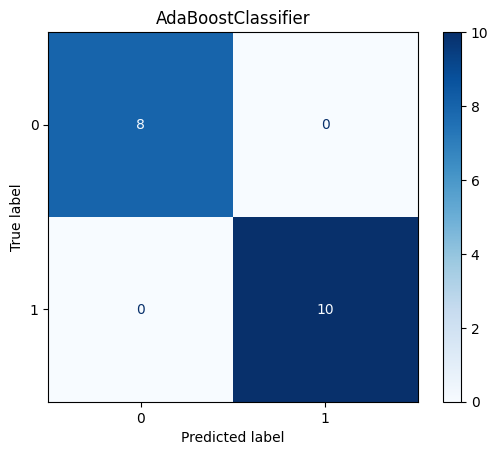

In [23]:
cm=models_undersampled_grd_t['cm'][0]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title('AdaBoostClassifier')
plt.show()

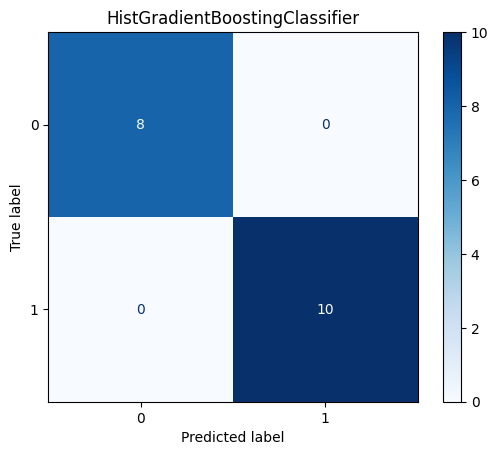

In [24]:
# models_undersampled_grd_t
cm=models_undersampled_grd_t['cm'][1]
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title('HistGradientBoostingClassifier')
plt.show()

In [25]:
# models_undersampled_grd_t
cm=models_undersampled_grd_t['cm'][2]
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title('ExtraTreesClassifier')
plt.show()

KeyError: 2

In [26]:
import pickle

import joblib 
# save model with joblib 
filename1 = 'Colon_CancerAdboost.sav'
filename2 = 'Colon_CancerHGB.sav'
joblib.dump(models_undersampled_grd[0], filename1)
joblib.dump(models_undersampled_grd[1], filename2)

# pickle.dump(models_undersampled_grd[0], open('/Users/shahadaleissa/Downloads/Code/SMOTEENN_Models/Adaboost_SMOTEENN.pkl','wb'))
# pickle.dump(models_undersampled_grd[2], open('/Users/shahadaleissa/Downloads/Code/SMOTEENN_Models/ET_SMOTEENN.pkl','wb'))
# pickle.dump(models_undersampled_grd[1], open('/Users/shahadaleissa/Downloads/Code/SMOTEENN_Models/HGB_SMOTEENN.pkl','wb'))

['Skin_CancerHGB.sav']

In [ ]:
|